1. Librerías necesarias

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats



AJUSTE DISTRIBUCIÓN  PUNTO A

In [32]:
demand_data = np.array([
    173, 212, 225, 199, 205, 176, 215, 198, 198, 184,
    199, 211, 233, 195, 217, 209, 177, 161, 175, 209,
    197, 206, 167, 196, 205, 219, 184, 172, 207, 191,
    164, 216, 163, 236, 183, 213, 195, 182, 238, 141,
    178, 211, 165, 213, 186, 202, 186, 194, 210, 206,
    196, 197, 236, 173, 199, 211, 168, 181, 206, 216,
    196, 201, 180, 209, 176, 221, 190, 206, 190, 210
])

estadística descriptiva

In [33]:
media= np.mean(demand_data)
mediana = np.median(demand_data)
desviacionstd = np.std(demand_data)
minimo = np.min(demand_data)
maximo = np.max(demand_data)
curtuosis = stats.kurtosis(demand_data)
print ("Media: ", media)
print ("Mediana: ", mediana)
print ("Curtuosis: ", curtuosis)

Media:  196.55714285714285
Mediana:  198.0
Curtuosis:  -0.13160850750515474


ajuste distribución normal

In [34]:
mu, sigma = stats.norm.fit(demand_data)

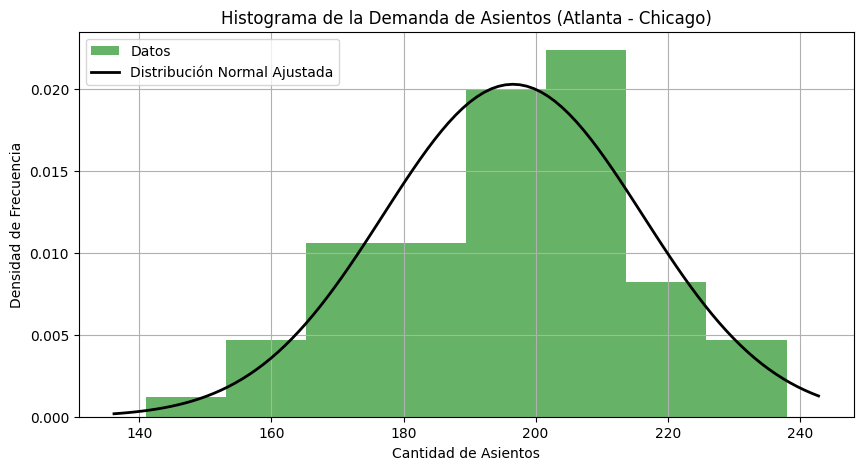

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(demand_data, bins="sturges", density=True, alpha=0.6, color='g', label="Datos")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label="Distribución Normal Ajustada")
plt.title("Histograma de la Demanda de Asientos (Atlanta - Chicago)")
plt.xlabel("Cantidad de Asientos")
plt.ylabel("Densidad de Frecuencia")
plt.legend()
plt.grid()
plt.show()

Intentamos la normal ya que la media: 196.5 y la mediana: 198 son valores cercanos, lo que nos indica que puede ser una distribución simétrica

TRIANGULAR

In [36]:
a = minimo
b = maximo
c = stats.mode(demand_data).mode #valor mas frecuente
print(a,b,c)

141 238 206


In [37]:
dist_triangular = stats.triang(c=(c-a)/(b-a), loc=a, scale=(b-a))

histograma

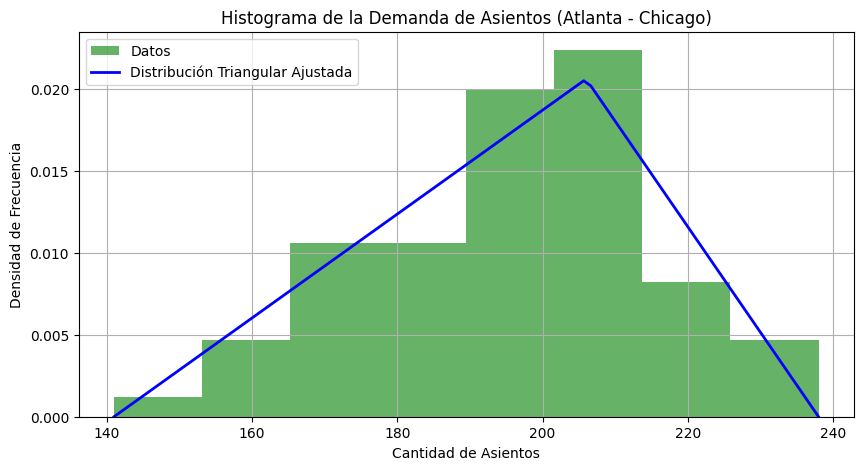

In [38]:
plt.figure(figsize=(10, 5))
plt.hist(demand_data, bins="sturges", density=True, alpha=0.6, color='g', label="Datos")
x = np.linspace(a, b, 100)
plt.plot(x, dist_triangular.pdf(x), 'b-', linewidth=2, label="Distribución Triangular Ajustada")
plt.title("Histograma de la Demanda de Asientos (Atlanta - Chicago)")
plt.xlabel("Cantidad de Asientos")
plt.ylabel("Densidad de Frecuencia")
plt.legend()
plt.grid()
plt.show()

Prueba de ajuste de bondad  Kolmogorov-Smirnov

In [39]:
# Para la normal: 
ks_norm_stat, ks_norm_pvalor = stats.kstest(demand_data, 'norm', args=(mu, sigma))

In [40]:
# Para la triangular:
c_param = (c-a)/(b-a)
ks_tri_stat, ks_tri_pvalue = stats.kstest(demand_data, 'triang', args=(c_param, a, b-a))

In [41]:
comparison_df = pd.DataFrame({
    'Distribución': ['Normal', 'Triangular'],
    'KS Estadístico': [ks_norm_stat, ks_tri_stat],
    'KS P-valor': [ks_norm_pvalor, ks_tri_pvalue]
})

comparison_df



,Distribución,KS Estadístico,KS P-valor
0,Normal,0.082714,0.693173
1,Triangular,0.076776,0.774804


Como el KS estadístico de la triangular es menor que la normal, y el valor P es mayor en la triangular que la normal, consideramos que la distribución que mejor se ajusta es la triangular.

MODELO

 Entradas conocidas

In [42]:
precios = {
    "Boston-Atlanta": {"Primera": 400, "Turista": 175},
    "Atlanta-Chicago": {"Primera": 400, "Turista": 150},
    "Chicago-Boston": {"Primera": 450, "Turista": 200},
}

COSTO_FIJO= 100000

# 3 filas primera clase,34 turista

FILAS_PRIMERA = 3
FILAS_TURISTA = 34
CAPACIDAD_PRIMERA = FILAS_PRIMERA*4
CAPACIDAD_TURISTA = FILAS_TURISTA*6

fracciones_primeraclase=[0.05, 0.12, 0.15]
probabilidades_primeraclase=[0.2, 0.5, 0.3]



 Entradas inciertas

<Axes: ylabel='Density'>

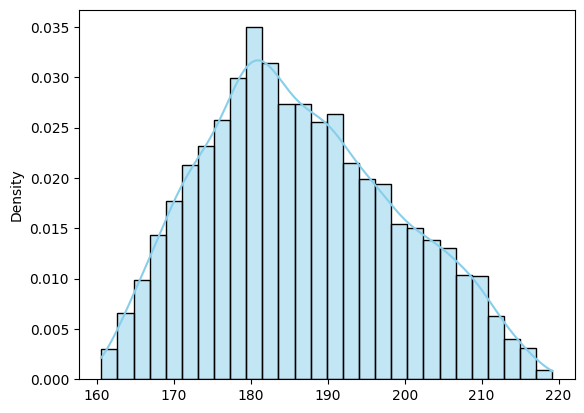

In [43]:
X = stats.triang(c=(180-160)/(220-160), loc=160, scale=(220-160)).rvs(5000)
sns.histplot(X, kde=True, stat="density", color="skyblue")

In [44]:
# demandas por cada tramo
demanda_tramos = {
    "Boston-Atlanta": stats.triang(c=(180-160)/(220-160), loc=160, scale=(220-160)),
    "Atlanta-Chicago": stats.triang(c=(c-a)/(b-a), loc=a, scale=(b-a)),
    "Chicago-Boston": stats.triang(c=(200-150)/(225-150), loc=150, scale=(225-150)),
}


Cálculos intermedios- SIMULACION PUNTO B

In [ ]:
def simulacion_beneficio(n_simulaciones=10000):
    beneficios = []
    for _ in range(n_simulaciones):
        ingreso_total = 0
        for tramo, dist_demanda in demanda_tramos.items():
            demanda_total = int(dist_demanda.rvs())  # Simular demanda total del tramo
            fraccion_pc = np.random.choice(fracciones_primeraclase, p=probabilidades_primeraclase)  # Fracción de primera clase
            
            demanda_pc = int(fraccion_pc * demanda_total)
            demanda_turista = demanda_total - demanda_pc
            
           
            ocupados_pc = min(demanda_pc, CAPACIDAD_PRIMERA)
            ocupados_turista = min(demanda_turista, CAPACIDAD_TURISTA)
            
           
            ingreso_pc = ocupados_pc * precios[tramo]["Primera"]
            ingreso_turista = ocupados_turista * precios[tramo]["Turista"]
            
            ingreso_total += ingreso_pc + ingreso_turista
        
       
        beneficio = ingreso_total - COSTO_FIJO
        beneficios.append(beneficio)
    
    
    return beneficios

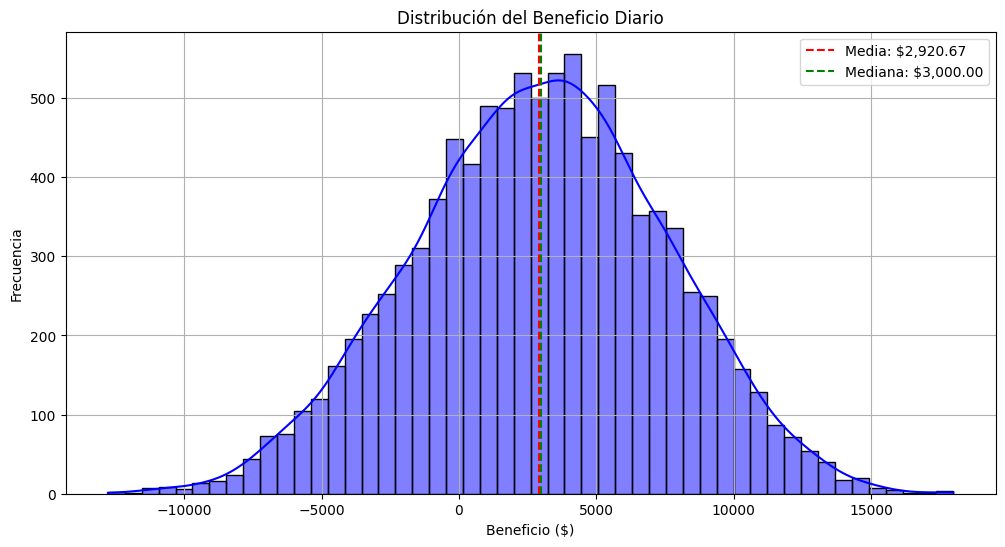

Beneficio esperado:  2920.67


In [ ]:

beneficios = simulacion_beneficio()  


beneficio_esperado = np.mean(beneficios)
percentiles = np.percentile(beneficios, [5, 25, 50, 75, 95])


plt.figure(figsize=(12, 6))
sns.histplot(beneficios, bins=50, kde=True, color="blue")
plt.axvline(beneficio_esperado, color="red", linestyle="dashed", label=f"Media: ${beneficio_esperado:,.2f}")
plt.axvline(percentiles[2], color="green", linestyle="dashed", label=f"Mediana: ${percentiles[2]:,.2f}")
plt.title("Distribución del Beneficio Diario")
plt.xlabel("Beneficio ($)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

print("Beneficio esperado: ", beneficio_esperado)

¿qué proporción de días Alpha estará al menos en equilibrio en el circuito Boston-Atlanta-Chicago-Boston? PUNTO C

Proporción de beneficios positivos:  73.92999999999999 %


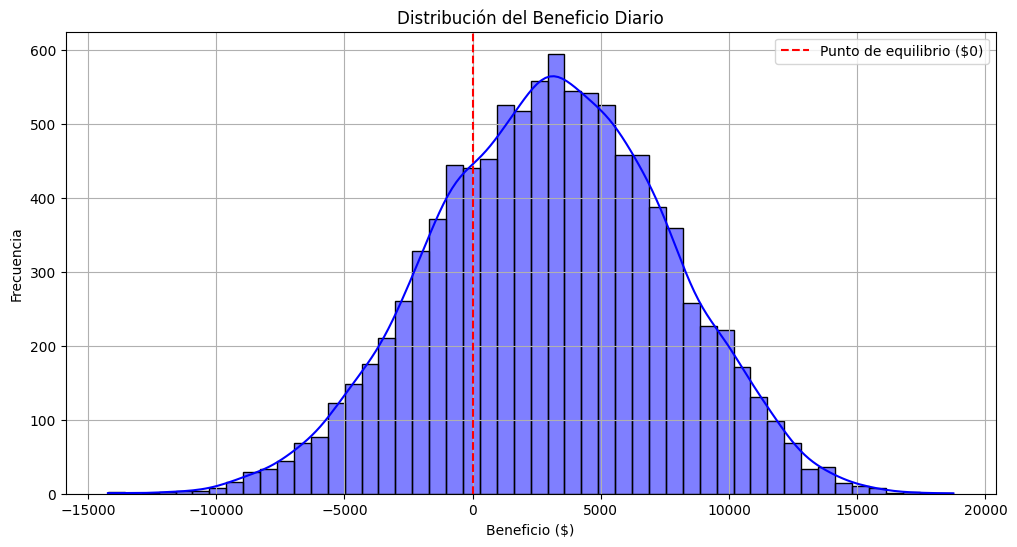

In [47]:
ArrayBeneficio = simulacion_beneficio()  


def contar_beneficios_positivos(ArrayBeneficio):
    Total = sum(1 for beneficio in ArrayBeneficio if beneficio >= 0)
    return Total

TotalBeneficiosPositivos = contar_beneficios_positivos(ArrayBeneficio)
Proporcion = TotalBeneficiosPositivos / len(ArrayBeneficio)

print("Proporción de beneficios positivos: ", Proporcion * 100, "%")

plt.figure(figsize=(12, 6))
sns.histplot(ArrayBeneficio, bins=50, kde=True, color="blue")
plt.axvline(0, color="red", linestyle="dashed", label="Punto de equilibrio ($0)")
plt.title("Distribución del Beneficio Diario")
plt.xlabel("Beneficio ($)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


Cuál es el máximo beneficio esperado y cuál es la configuración de asientos que lo consigue? 

 

In [48]:

def encontrar_configuracion_optima(n_simulaciones=10000):
    resultados = []
    
    for filas_pc in range(0, 21):  
        filas_turista = 40 - (2 * filas_pc)  
        
        if filas_turista < 0:  
            continue
        
        capacidad_pc = filas_pc * 4  
        capacidad_turista = filas_turista * 6  

        def simulacion_beneficio_config(n_simulaciones):
            beneficios = []
            for _ in range(n_simulaciones):
                ingreso_total = 0
                for tramo, dist_demanda in demanda_tramos.items():
                    demanda_total = int(dist_demanda.rvs())  
                    fraccion_pc = np.random.choice(fracciones_primeraclase, p=probabilidades_primeraclase)  

                    demanda_pc = int(fraccion_pc * demanda_total)
                    demanda_turista = demanda_total - demanda_pc

                    
                    ocupados_pc = min(demanda_pc, capacidad_pc)
                    ocupados_turista = min(demanda_turista, capacidad_turista)

                    
                    ingreso_pc = ocupados_pc * precios[tramo]["Primera"]
                    ingreso_turista = ocupados_turista * precios[tramo]["Turista"]

                    ingreso_total += ingreso_pc + ingreso_turista

              
                beneficio = ingreso_total - COSTO_FIJO
                beneficios.append(beneficio)

            return np.mean(beneficios)

       
        beneficio_esperado = simulacion_beneficio_config(n_simulaciones)
        resultados.append((filas_pc, filas_turista, beneficio_esperado))

  
    df_resultados = pd.DataFrame(resultados, columns=["Filas_Primera", "Filas_Turista", "Beneficio_Esperado"])
    
    
    mejor_config = df_resultados.loc[df_resultados["Beneficio_Esperado"].idxmax()]
    
    return df_resultados, mejor_config

df_configuraciones, mejor_configuracion = encontrar_configuracion_optima()


print(df_configuraciones.to_string(index=False))


mejor_configuracion


 Filas_Primera  Filas_Turista  Beneficio_Esperado
             0             40         -11360.2550
             1             38          -6283.3975
             2             36          -1357.7200
             3             34           2986.4925
             4             32           6729.5100
             5             30           9578.3375
             6             28          10142.5750
             7             26           7354.4425
             8             24           2378.3425
             9             22          -3885.8650
            10             20         -10120.1200
            11             18         -16434.9500
            12             16         -22757.3700
            13             14         -28997.5600
            14             12         -35344.1650
            15             10         -41707.7500
            16              8         -47985.1350
            17              6         -54287.1550
            18              4         -60570.2650


Filas_Primera             6.000
Filas_Turista            28.000
Beneficio_Esperado    10142.575
Name: 6, dtype: float64